# **Workshop -001: Extract**

**Importación de las librerias a utilizar**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

**Defincion de funcion para utilizar OneHotEncoder**

In [26]:
def one_hot_encode(df, columns):
    encoder = OneHotEncoder(sparse_output=False, drop='first') 
    encoded_data = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns))
    return pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

**Leemos los datos del archivo JSON linea por linea**

In [27]:
data = []

with open('MLA_100k.jsonlines', 'r', encoding='utf-8') as file:
    for line in file:
        item = json.loads(line)
        
        condition = item.get('condition', '')
        listing_type_id = item.get('listing_type_id', '')
        price = item.get('price', 0.0)
        currency_id = item.get('currency_id','')
        buying_mode = item.get('buying_mode', '')
        accepts_mercadopago = item.get('accepts_mercadopago', False)
        automatic_relist = item.get('automatic_relist', False)
        status = item.get('status', '')
        
        seller_address = item.get('seller_address', {})
        seller_address_longitude = pd.to_numeric(seller_address.get('longitude'), errors='coerce')
        seller_address_longitude = seller_address_longitude if not pd.isna(seller_address_longitude) else 0.0
        seller_address_latitude = pd.to_numeric(seller_address.get('latitude'), errors='coerce')
        seller_address_latitude = seller_address_latitude if not pd.isna(seller_address_latitude) else 0.0
        seller_address_country = seller_address.get('country', {})
        seller_address_country_id = seller_address_country.get('id','')
        #seller_address.get('city', {}).get('id', '')
        seller_address_city = seller_address.get('city', {})
        seller_address_city_id = seller_address_country.get('id','')
     
        shipping = item.get('shipping', {})
        shipping_local_pick_up = shipping.get('local_pick_up', False)
        shipping_free_shipping = shipping.get('free_shipping', False)
        shipping_mode = shipping.get('mode', 'not_specified')
        
        non_mercado_pago_methods = item.get('non_mercado_pago_payment_methods', [])
        cash_payment = False  
        transfer_payment = False        
        for method in non_mercado_pago_methods:
            method_id = method.get('id', '')
            if method_id == 'MLAMO':
                cash_payment = True 
            elif method_id == 'MLATB':
                transfer_payment = True        

        date_created = item.get('date_created', '')
        last_updated = item.get('last_updated', '')
        date_created_dt = datetime.strptime(date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
        last_updated_dt = datetime.strptime(last_updated, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        Year_created = date_created_dt.year
        Month_created = date_created_dt.strftime('%B')
        day_name_created = date_created_dt.strftime('%A')
        Hour_created = date_created_dt.hour
        Min_created = date_created_dt.minute
        
        Month_updated = last_updated_dt.strftime('%B')
        day_name_updated = last_updated_dt.strftime('%A')
        Hour_updated = last_updated_dt.hour
        Min_updated = last_updated_dt.minute
        
        data.append([
            condition, listing_type_id, price, currency_id, buying_mode, accepts_mercadopago,
            cash_payment,transfer_payment,
            automatic_relist, status, seller_address_longitude, seller_address_latitude,
            seller_address_country_id,seller_address_city_id,
            shipping_local_pick_up, shipping_free_shipping, shipping_mode,
            Year_created, Month_created, day_name_created, Hour_created, Min_created,
            Month_updated, day_name_updated, Hour_updated, Min_updated
        ])

columns = [
    'condition', 'listing_type_id', 'price', 'currency_id', 'buying_mode', 'accepts_mercadopago',
    'cash_payment','transfer_payment',
    'automatic_relist', 'status', 'seller_address_longitude', 'seller_address_latitude',
    'seller_address_country_id', 'seller_address_city_id', 
    'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
    'Year_created', 'Month_created', 'day_name_created', 'Hour_created', 'Min_created',
    'Month_updated', 'day_name_updated', 'Hour_updated', 'Min_updated'
]

df = pd.DataFrame(data, columns=columns)


**Graficar cantidad de articulos nuevos y usados**

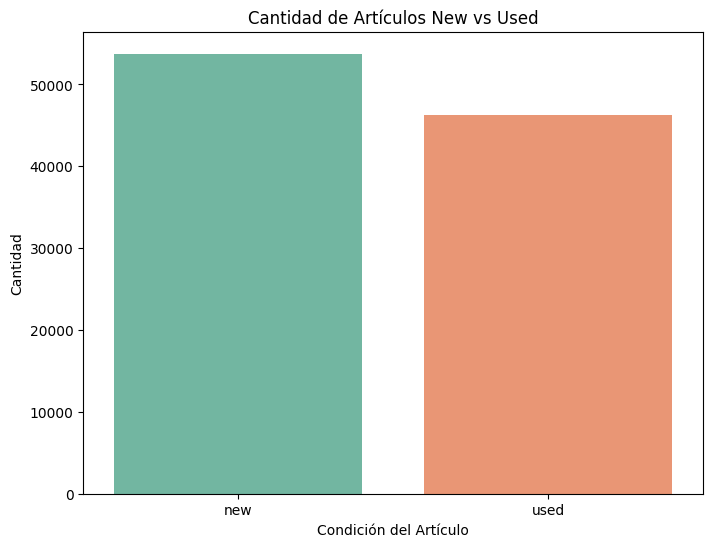

In [28]:
# Gráfica de comparación de artículos nuevos y usados
plt.figure(figsize=(8, 6))
sns.countplot(x='condition', data=df, hue='condition', palette='Set2', legend=False)
plt.title('Cantidad de Artículos New vs Used')
plt.xlabel('Condición del Artículo')
plt.ylabel('Cantidad')
plt.show()

**Ahora miremos graficas de correlación de los productos, para las variables new y used**

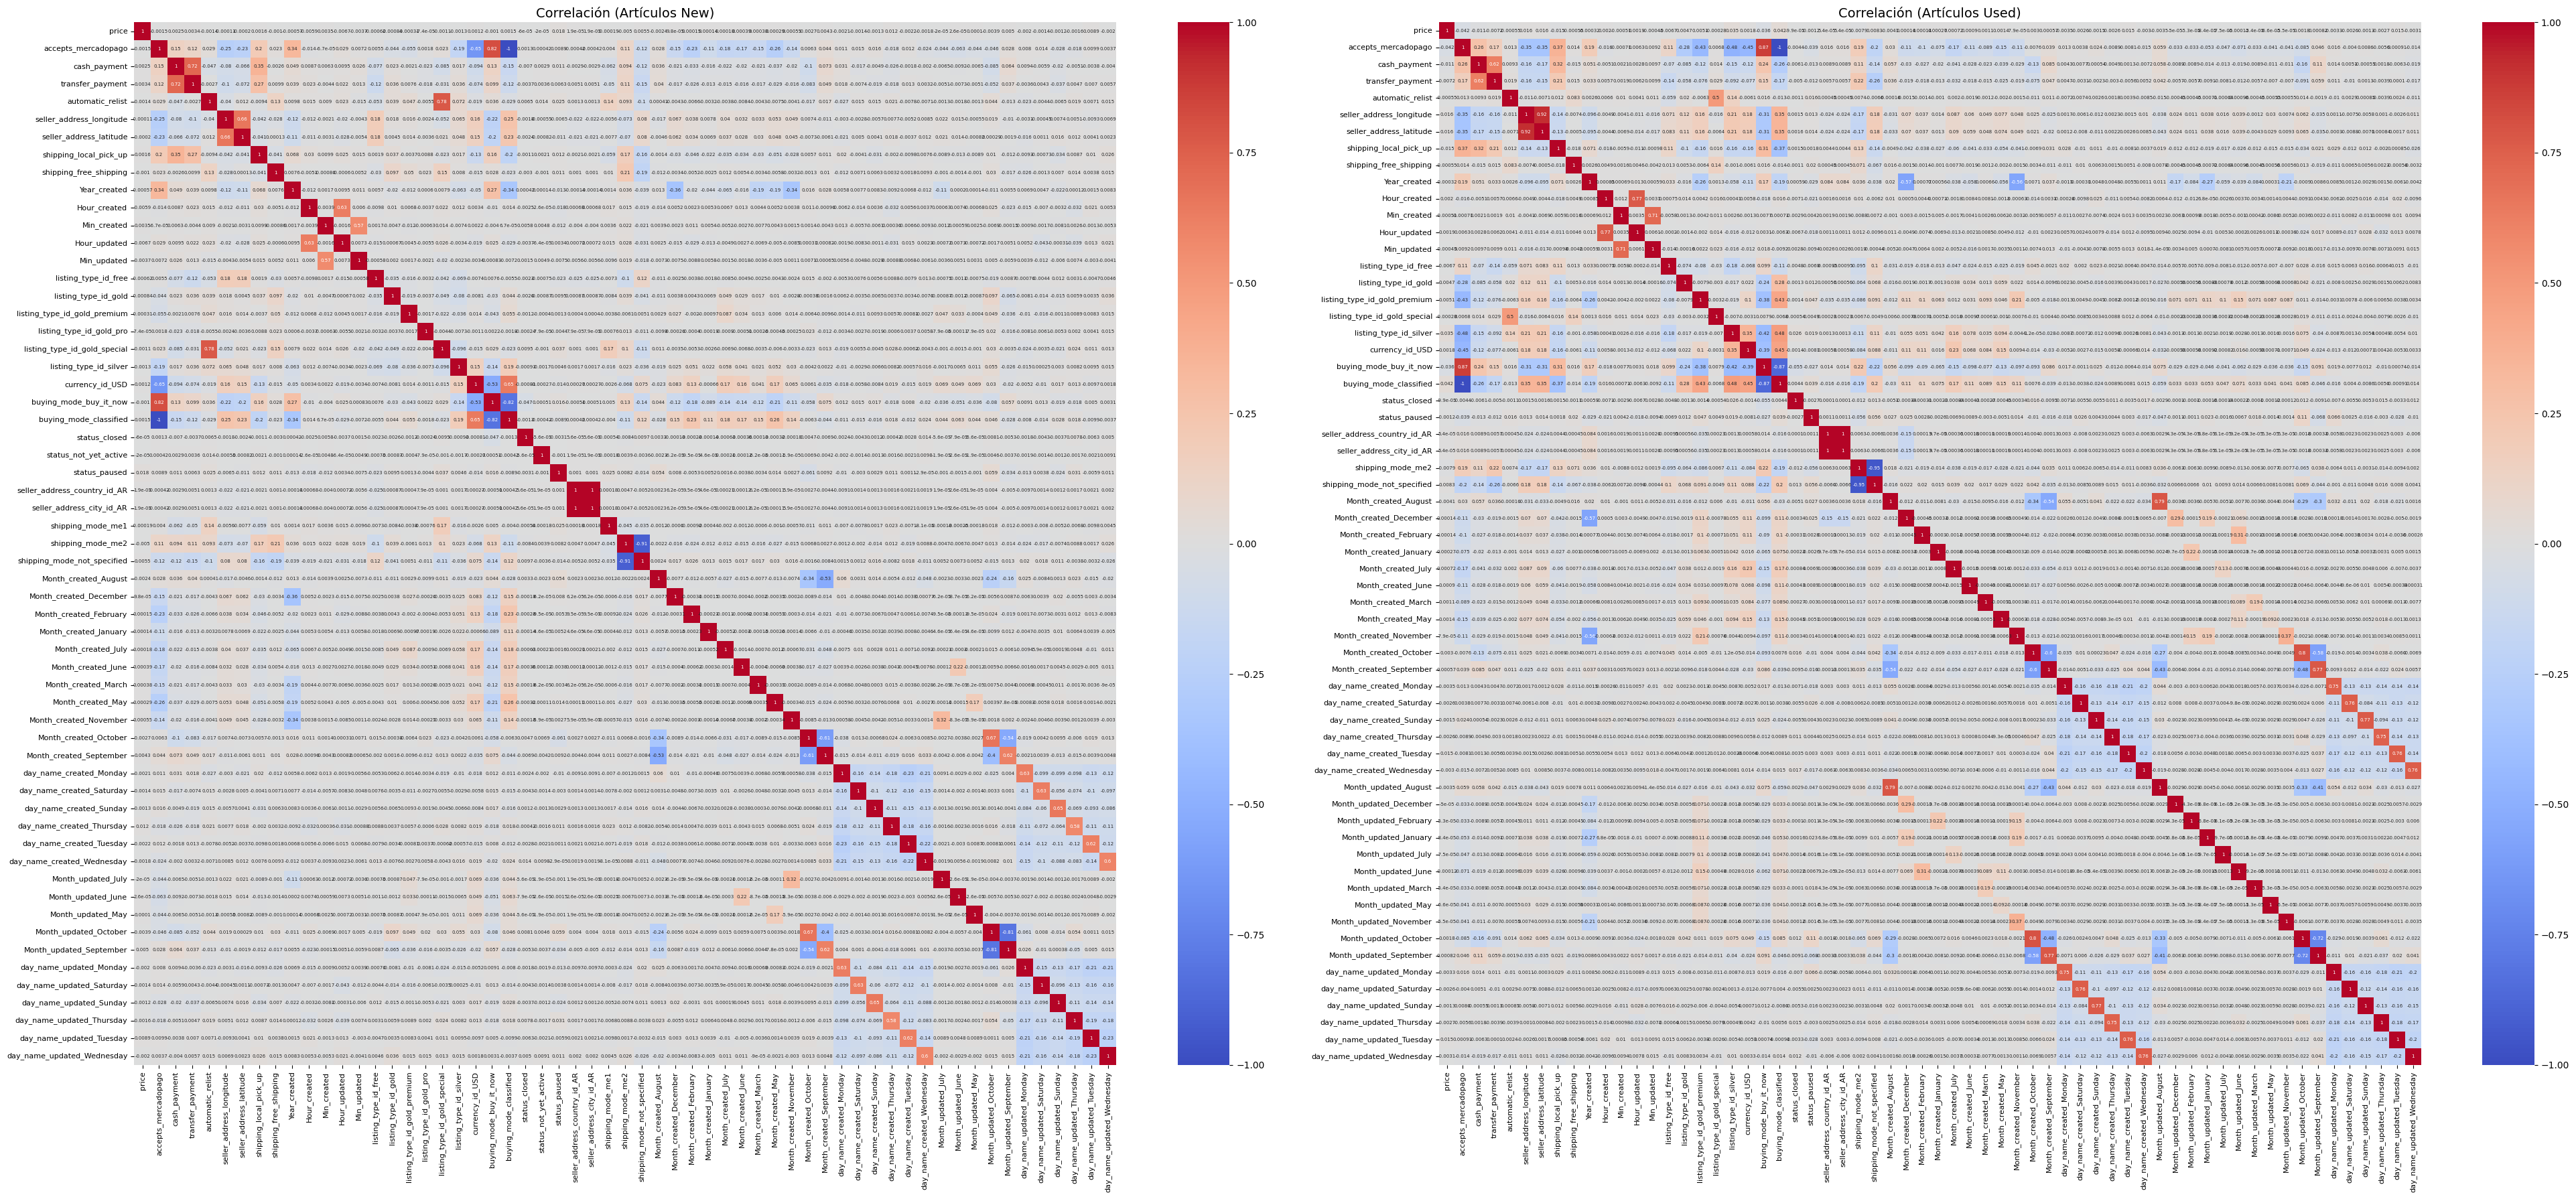

In [29]:
df_new = df[df['condition'] == 'new'].copy() 
df_used = df[df['condition'] == 'used'].copy() 

bool_columns = ['accepts_mercadopago', 'automatic_relist', 'cash_payment', 'transfer_payment',
                'shipping_local_pick_up', 'shipping_free_shipping']
df_new[bool_columns] = df_new[bool_columns].astype(int)
df_used[bool_columns] = df_used[bool_columns].astype(int)

categorical_columns = ['listing_type_id', 'currency_id', 'buying_mode', 'status',
                       'seller_address_country_id', 'seller_address_city_id', 'shipping_mode',
                       'Month_created', 'day_name_created', 'Month_updated', 'day_name_updated']

df_new_encoded = one_hot_encode(df_new, categorical_columns)
df_used_encoded = one_hot_encode(df_used, categorical_columns)

numeric_columns_new = df_new_encoded.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_used = df_used_encoded.select_dtypes(include=['float64', 'int64']).columns

corr_new = df_new_encoded[numeric_columns_new].corr()
corr_used = df_used_encoded[numeric_columns_used].corr()


#corr_new = df_new[['listing_type_id','price','currency_id','buying_mode','accepts_mercadopago','cash_payment','transfer_payment','automatic_relist',
#                    'status','seller_address_longitude', 'seller_address_latitude', 'seller_address_country_id', 'seller_address_city_id',
#                     'shipping_local_pick_up','shipping_free_shipping', 'shipping_mode',  'Year_created', 'Month_created', 'day_name_created',
#                     'Hour_created', 'Min_created', 'Month_updated', 'day_name_updated', 'Hour_updated', 'Min_updated']].corr()

#corr_used = df_used[['listing_type_id','price','currency_id','buying_mode','accepts_mercadopago','cash_payment','transfer_payment','automatic_relist',
#                    'status','seller_address_longitude', 'seller_address_latitude', 'seller_address_country_id', 'seller_address_city_id',
#                     'shipping_local_pick_up','shipping_free_shipping', 'shipping_mode',  'Year_created', 'Month_created', 'day_name_created',
#                     'Hour_created', 'Min_created', 'Month_updated', 'day_name_updated', 'Hour_updated', 'Min_updated']].corr()

plt.figure(figsize=(40, 18))  
plt.subplot(1, 2, 1)
sns.heatmap(corr_new, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 5}) 
plt.title('Correlación (Artículos New)', fontsize=14)
plt.xticks(rotation=90, fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  

plt.subplot(1, 2, 2)
sns.heatmap(corr_used, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={'size': 5})  
plt.title('Correlación (Artículos Used)', fontsize=14)
plt.xticks(rotation=90, fontsize=8)  
plt.yticks(rotation=0, fontsize=8) 

plt.tight_layout()  
plt.show()

**Luego del resultado de la matriz de correlación, exportamos los datos de la primera transformación a un archivo CSV**

***Con este informacion antes de entrenar el modelo, realizaremos otras transformacion donde tomaremos las caracteristica mas importantes de entrenar el modelo teniendo en cuenta la matriz de correlación*** 

In [30]:
df.to_csv('clean_processed_data.csv', index=False, encoding='utf-8')
